<h1>Più liberi o più felici?</h1>
<p>Esplorando il legame tra Felicità e Libertà nel contesto globale</p>

<h2>Overview</h2>
<p>Questo studio si propone di fornire una panoramica della percezione media mondiale del senso di felicità e del senso di libertà nel periodo compreso tra il 2015 e il 2019, cercando di rispondere alle seguenti domande:</p>

<ul>
    <li><strong>Qual è la distribuzione di Felicità e Libertà e cosa le caratterizza?</strong> </li>
    <li><strong>Qual è il legame tra Felicità e Libertà?</strong></li>
    <li><strong>Qual è la percezione Mondiale di Felicità e Libertà?</strong></li>
</ul>

In [462]:
#import library

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import geopandas as gpd
from sklearn.preprocessing import StandardScaler

import warnings
from shapely.errors import ShapelyDeprecationWarning


<h2>Data Sources</h2>

<p>Per l'analisi sono stati presi in considerazione i seguenti dataset con riferimento agli anni 2015-2019:</p>

<ul>
    <li><a href="https://www.kaggle.com/datasets/gsutters/the-human-freedom-index">Human Freedom</a></li> 
    che offre una panoramica mondiale di come le nazioni percepiscono il senso di libertà
    <li><a href="https://www.kaggle.com/datasets/unsdsn/world-happiness">World Happiness Report</a></li> Che offre una panoramica mondiale di come le nazioni percepiscono il senso di felicità
</ul>

<h2>Struttura dei dataset</h2>
<p>Entrambi i dataset hanno la seguente struttura delle colonne:

<strong>Primary key (country-year):</strong> ogni riga in entrambi i dataset è caratterizzata dalla chiave nazione-anno

<strong>Total Score:</strong> ogni dataset ha una colonna <i>score</i>, che indica il punteggio di felicità o libertà stimato in una scala [0-10]

<strong>Contributors:</strong> una serie di colonne che influenzano il total score rispetto al proprio dataset, relative alle stime per le sottoaree dei loro rispettivi componenti
 </p>

## Glossario

<p>Con riferimento al dataset della Libertà, di seguito vengono riportati gli acronimi che verranno usati più frequentemente:</p>
<ul>
<li><strong>hf_score</strong>: <i>Human Freedom</i>, è una media tra pf_score e ef_score</li>
<li><strong>pf_score_</strong>: <i>Personal Freedom</i>, è una media tra una serie di variabili che hanno impatto sulla felicità personale</li>
<li><strong>ef_score_</strong>: <i>Economic Freedom</i>, è una media tra una serie di variabili che hanno impatto sulla felicità economica</li>
</ul>

In [463]:

#Freedom Dictionary
data = {
    'hf_score': {'pf_score': {'pf_rol': 'rule&role',
                              'pf_ss': 'security&safety',
                              'pf_movement': 'movement',
                              'pf_religion': 'religion',
                              'pf_expression': 'expression and information',
                              'pf_identity': 'identity and relationship',
                              'pf_association': 'association, assembly and civil society'},
                 'ef_score': {'ef_government': 'government',
                              'ef_gender': 'gender',
                              'ef_legal': 'legal system and property right',
                              'ef_money': 'access to sound money',
                              'ef_trade': 'freedom to trade internationally',
                              'ef_regulation': 'regulation of credit and business'}}
}

# Funzione ricorsiva per creare il diagramma
def plot_tree(data, parent=None, level=0):
    if parent:
        print("  " * level + f"- {parent}")
    for key, value in data.items():
        if isinstance(value, dict):
            plot_tree(value, parent=key, level=level+1)
        else:
            print("  " * (level+1) + f"- {key}: {value}")

In [464]:
#panoramica delle variabili che influenzano libertà personale ed economica 
plot_tree(data)

  - hf_score
    - pf_score
      - pf_rol: rule&role
      - pf_ss: security&safety
      - pf_movement: movement
      - pf_religion: religion
      - pf_expression: expression and information
      - pf_identity: identity and relationship
      - pf_association: association, assembly and civil society
    - ef_score
      - ef_government: government
      - ef_gender: gender
      - ef_legal: legal system and property right
      - ef_money: access to sound money
      - ef_trade: freedom to trade internationally
      - ef_regulation: regulation of credit and business


In [465]:
#import dataset

#human_freedom
hf22 = pd.read_csv('dataset/human_freedom_index/hfi_cc_2022.csv')

#world_happiness
wh15 = pd.read_csv('dataset/world_happiness_report/2015.csv')
wh16 = pd.read_csv('dataset/world_happiness_report/2016.csv')
wh17 = pd.read_csv('dataset/world_happiness_report/2017.csv')
wh18 = pd.read_csv('dataset/world_happiness_report/2018.csv')
wh19 = pd.read_csv('dataset/world_happiness_report/2019.csv')

# geospatial data
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Data Cleaning

<p>Di seguito verrà fatta un operazione di data cleaning per i 2 dataset separatamente. 
Dopo questa prima fase, seguirà una valutazione della consistenza dei dati tra i due dataset e il dataset world</p>

## Human Freedom - Data Cleaning

In [466]:
hf22.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3465 entries, 0 to 3464
Columns: 141 entries, year to ef_rank
dtypes: float64(133), int64(3), object(5)
memory usage: 3.7+ MB


In [467]:
hf22.sample(5)

,year,countries,region,hf_score,hf_rank,hf_quartile,pf_rol_procedural,pf_rol_civil,pf_rol_criminal,pf_rol_vdem,...,ef_regulation_business_adm,ef_regulation_business_burden,ef_regulation_business_start,ef_regulation_business_impartial,ef_regulation_business_licensing,ef_regulation_business_compliance,ef_regulation_business,ef_regulation,ef_score,ef_rank
3458,2000,United States,North America,8.97,6.0,1.0,NaN,NaN,NaN,8.019851,...,7.918250,8.150000,9.800548,9.5025,NaN,6.356969,8.345653,8.598604,8.70,3.0
2808,2003,Argentina,Latin America & the Caribbean,7.68,48.0,2.0,NaN,NaN,NaN,6.770866,...,2.166667,5.500000,8.826516,6.4675,NaN,4.922175,5.576572,6.143312,6.25,84.0
322,2019,United Kingdom,Western Europe,8.79,15.0,1.0,8.408518,7.078331,7.131065,7.577389,...,5.560803,6.444444,9.855926,9.7225,9.515020,8.722137,8.303472,8.435807,8.16,11.0
64,2020,Haiti,Latin America & the Caribbean,6.78,82.0,2.0,3.338278,4.121954,2.818183,4.790564,...,2.319556,0.666667,4.970680,2.2100,9.297921,7.937484,4.567051,6.885342,6.57,96.0
1639,2011,Uganda,Sub-Saharan Africa,6.33,110.0,3.0,2.733333,5.128122,4.308519,5.673815,...,4.722277,4.848485,8.137762,5.5475,7.336823,7.612413,6.367543,7.903579,7.16,65.0


In [468]:
#Rename columns
hf22.rename(columns = {'countries':'country'}, inplace = True) 

#Since assembly is a subarea of ​​association, the columns were renamed correctly
hf22.columns = ['pf_association_assembly' + c.split('pf_assembly', 1)[1] if c.startswith('pf_assembly') else c for c in hf22.columns]
hf22['pf_association'] = hf22['pf_association_assembly']

In [469]:
#get all rows between [2015-2019]
freedom_data = hf22[(hf22['year'] >= 2015) & (hf22['year'] <= 2019)]
freedom_data.reset_index(inplace=True)

In [470]:
#get only relevant columns
principal_columns = [c for c in freedom_data.columns.values if c.count('_') <= 1]
freedom_data = freedom_data[principal_columns]

#the columns not of interest are eliminated
freedom_data = freedom_data.drop(['index', 'hf_rank', 'hf_quartile', 'pf_rank', 'ef_rank'], axis=1)
freedom_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            825 non-null    int64  
 1   country         825 non-null    object 
 2   region          825 non-null    object 
 3   hf_score        810 non-null    float64
 4   pf_rol          820 non-null    float64
 5   pf_ss           825 non-null    float64
 6   pf_movement     825 non-null    float64
 7   pf_religion     825 non-null    float64
 8   pf_expression   825 non-null    float64
 9   pf_identity     825 non-null    float64
 10  pf_score        810 non-null    float64
 11  ef_government   813 non-null    float64
 12  ef_gender       819 non-null    float64
 13  ef_legal        813 non-null    float64
 14  ef_money        810 non-null    float64
 15  ef_trade        810 non-null    float64
 16  ef_regulation   810 non-null    float64
 17  ef_score        810 non-null    flo

In [471]:
freedom_data.describe()

,year,hf_score,pf_rol,pf_ss,pf_movement,pf_religion,pf_expression,pf_identity,pf_score,ef_government,ef_gender,ef_legal,ef_money,ef_trade,ef_regulation,ef_score,pf_association
count,825.000000,810.000000,820.000000,825.000000,825.000000,825.000000,825.000000,825.000000,810.000000,813.000000,819.000000,813.000000,810.000000,810.000000,810.000000,810.000000,825.000000
mean,2017.000000,7.050062,5.230124,8.008548,8.140872,7.833929,6.374055,7.262247,7.170309,6.740107,0.853193,5.317495,8.310200,7.024498,6.998239,6.880407,7.056554
std,1.415071,1.295606,1.659174,1.728828,1.809325,2.141906,2.327652,2.775878,1.693884,1.121998,0.184793,1.580576,1.439566,1.417460,1.101405,0.991370,2.439807
min,2015.000000,3.150000,1.552202,1.566268,2.082083,0.000000,0.433456,0.000000,2.080000,2.380000,0.294118,2.123833,0.944935,1.002673,2.497275,2.720000,1.137917
25%,2016.000000,6.142500,3.931324,7.281366,7.150417,6.736667,4.586654,5.000000,5.812500,5.937787,0.823529,4.296775,7.282118,6.063888,6.431694,6.205000,5.480972
50%,2017.000000,7.120000,4.898606,8.464274,8.079167,8.665000,6.667200,8.125000,7.440000,6.776254,0.941176,5.137943,8.687929,7.166840,7.097546,7.030000,7.785046
75%,2018.000000,8.097500,6.509015,9.349449,9.810417,9.596250,8.071958,9.375000,8.537500,7.550400,1.000000,6.316099,9.436710,8.220009,7.763873,7.657500,9.109792
max,2019.000000,9.200000,8.834741,9.928349,10.000000,10.000000,9.939750,10.000000,9.690000,9.287349,1.000000,8.921169,9.904163,9.555910,9.429423,9.010000,10.000000


In [472]:
freedom_data.filter(like='ef_').describe()

,ef_government,ef_gender,ef_legal,ef_money,ef_trade,ef_regulation,ef_score
count,813.000000,819.000000,813.000000,810.000000,810.000000,810.000000,810.000000
mean,6.740107,0.853193,5.317495,8.310200,7.024498,6.998239,6.880407
std,1.121998,0.184793,1.580576,1.439566,1.417460,1.101405,0.991370
min,2.380000,0.294118,2.123833,0.944935,1.002673,2.497275,2.720000
25%,5.937787,0.823529,4.296775,7.282118,6.063888,6.431694,6.205000
50%,6.776254,0.941176,5.137943,8.687929,7.166840,7.097546,7.030000
75%,7.550400,1.000000,6.316099,9.436710,8.220009,7.763873,7.657500
max,9.287349,1.000000,8.921169,9.904163,9.555910,9.429423,9.010000


<p>'ef_gender' ha un andamento anomalo. 
I suoi valori oscillano tra [0-1] piuttosto che tra [0-10].
La media tra tutti i valori delle colonne relative all'analisi della libertà, non restisce ef_score se presa in considerazione la colonna ef_gender.

Per questi motivi è stato scelto di eliminare la colonna 
</p>

In [473]:
freedom_data = freedom_data.drop(['ef_gender'], axis=1)

In [474]:
#get info about principal columns in freedom_data dataframe
freedom_data[["hf_score", "pf_score", "ef_score"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   hf_score  810 non-null    float64
 1   pf_score  810 non-null    float64
 2   ef_score  810 non-null    float64
dtypes: float64(3)
memory usage: 19.5 KB


In [475]:
freedom_data[freedom_data[["hf_score", "pf_score", "ef_score"]].isna().any(axis=1)].info()

<class 'pandas.core.frame.DataFrame'>
Index: 15 entries, 199 to 800
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            15 non-null     int64  
 1   country         15 non-null     object 
 2   region          15 non-null     object 
 3   hf_score        0 non-null      float64
 4   pf_rol          15 non-null     float64
 5   pf_ss           15 non-null     float64
 6   pf_movement     15 non-null     float64
 7   pf_religion     15 non-null     float64
 8   pf_expression   15 non-null     float64
 9   pf_identity     15 non-null     float64
 10  pf_score        0 non-null      float64
 11  ef_government   3 non-null      float64
 12  ef_legal        3 non-null      float64
 13  ef_money        0 non-null      float64
 14  ef_trade        0 non-null      float64
 15  ef_regulation   0 non-null      float64
 16  ef_score        0 non-null      float64
 17  pf_association  15 non-null     float64

Le colonne "hf_score", "pf_score", "ef_score", sono particolarmente significative. Per questo motivo è stato deciso di eliminare le righe che hanno almeno una dei 3 campi valorizzato a nan, valutando essere un numero esiguo (15/825).

In [476]:
freedom_data.dropna(subset=["hf_score", "pf_score", "ef_score"], how='any', inplace=True)
freedom_data[["hf_score", "pf_score", "ef_score"]].info()

<class 'pandas.core.frame.DataFrame'>
Index: 810 entries, 0 to 824
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   hf_score  810 non-null    float64
 1   pf_score  810 non-null    float64
 2   ef_score  810 non-null    float64
dtypes: float64(3)
memory usage: 25.3 KB


In [477]:
freedom_data.head(5)

,year,country,region,hf_score,pf_rol,pf_ss,pf_movement,pf_religion,pf_expression,pf_identity,pf_score,ef_government,ef_legal,ef_money,ef_trade,ef_regulation,ef_score,pf_association
0,2019,Albania,Eastern Europe,8.07,4.892466,9.350083,9.868750,9.737500,6.248600,8.75,8.27,7.914393,5.258757,9.826979,8.230921,7.700885,7.79,9.051458
1,2019,Algeria,Middle East & North Africa,5.08,4.890457,8.952936,5.927500,5.236667,4.586654,2.50,5.24,4.493472,4.142208,7.287095,2.549231,5.840164,4.86,4.561065
2,2019,Angola,Sub-Saharan Africa,5.96,3.534740,8.463164,7.617917,6.736667,5.500711,6.25,6.25,8.052209,3.667891,4.665603,5.406230,5.974672,5.55,5.631134
3,2019,Argentina,Latin America & the Caribbean,7.33,5.574289,8.404363,9.760833,9.859375,8.205444,10.00,8.68,6.547886,4.797548,3.879031,5.975559,5.994265,5.44,8.959514
4,2019,Armenia,Caucasus & Central Asia,8.32,7.287006,9.264917,9.844167,8.338542,7.617444,8.75,8.56,7.769871,6.250506,9.519745,8.525586,7.819774,7.98,8.817963


In [478]:
freedom_data[['hf_score', 'pf_score', 'ef_score']].describe()

,hf_score,pf_score,ef_score
count,810.000000,810.000000,810.000000
mean,7.050062,7.170309,6.880407
std,1.295606,1.693884,0.991370
min,3.150000,2.080000,2.720000
25%,6.142500,5.812500,6.205000
50%,7.120000,7.440000,7.030000
75%,8.097500,8.537500,7.657500
max,9.200000,9.690000,9.010000


## Happiness Report - Data Cleaning

In [479]:
#Merge all single dataset [2015-2019] and return dataset happiness_data
#Uniform columns name

#drop columns 
wh15 = wh15.drop(columns=['Region', 'Standard Error', 'Dystopia Residual'], axis=1)
wh16 = wh16.drop(columns=['Region', 'Lower Confidence Interval', 'Upper Confidence Interval', 'Dystopia Residual'], axis=1)
wh17 = wh17.drop(columns=['Whisker.high', 'Whisker.low', 'Dystopia.Residual'], axis=1)


#rename columns
wh19 = wh19.rename(columns={"Country or region": "country",
                     "Overall rank": "happiness_rank", 
                     "Score": "happiness_score",
                     "GDP per capita": "economy",
                     "Social support": "family",
                     "Healthy life expectancy": "health",
                     "Freedom to make life choices": "freedom",
                     "Perceptions of corruption": "trust",
                     "Generosity": "generosity"
                     })

wh18 = wh18.rename(columns={"Country or region": "country",
                     "Overall rank": "happiness_rank", 
                     "Score": "happiness_score",
                     "GDP per capita": "economy",
                     "Social support": "family",
                     "Healthy life expectancy": "health",
                     "Freedom to make life choices": "freedom",
                     "Perceptions of corruption": "trust",
                     "Generosity": "generosity"
                     })

wh17 = wh17.rename(columns={"Country": "country",
                     "Happiness.Rank": "happiness_rank", 
                     "Happiness.Score": "happiness_score",
                     "Economy..GDP.per.Capita.": "economy",
                     "Family": "family",
                     "Health..Life.Expectancy.": "health",
                     "Freedom": "freedom",
                     "Trust..Government.Corruption.": "trust",
                     "Generosity": "generosity"
                     })

wh16 = wh16.rename(columns={"Country": "country",
                     "Happiness Rank": "happiness_rank", 
                     "Happiness Score": "happiness_score",
                     "Economy (GDP per Capita)": "economy",
                     "Family": "family",
                     "Health (Life Expectancy)": "health",
                     "Freedom": "freedom",
                     "Trust (Government Corruption)": "trust",
                     "Generosity": "generosity"
                     })

wh15 = wh15.rename(columns={"Country": "country",
                     "Happiness Rank": "happiness_rank", 
                     "Happiness Score": "happiness_score",
                     "Economy (GDP per Capita)": "economy",
                     "Family": "family",
                     "Health (Life Expectancy)": "health",
                     "Freedom": "freedom",
                     "Trust (Government Corruption)": "trust",
                     "Generosity": "generosity"
                     })

#add column year for every dataframe
wh15['year'] = 2015
wh16['year'] = 2016
wh17['year'] = 2017
wh18['year'] = 2018
wh19['year'] = 2019

frames = [wh15, wh16, wh17, wh18, wh19]
happiness_data = pd.concat(frames)

In [480]:
happiness_data.info()
print("Unique countries: ", happiness_data.country.nunique())

<class 'pandas.core.frame.DataFrame'>
Index: 782 entries, 0 to 155
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   country          782 non-null    object 
 1   happiness_rank   782 non-null    int64  
 2   happiness_score  782 non-null    float64
 3   economy          782 non-null    float64
 4   family           782 non-null    float64
 5   health           782 non-null    float64
 6   freedom          782 non-null    float64
 7   trust            781 non-null    float64
 8   generosity       782 non-null    float64
 9   year             782 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 67.2+ KB
Unique countries:  170


In [481]:
#drop irrilevant columns
happiness_data = happiness_data.drop(columns=['happiness_rank'])

Rendiamo i dataframe consistenti tra loro

In [482]:
print(freedom_data[~freedom_data['country'].isin(world['name'])]['country'].unique())
print('')
print(happiness_data[~happiness_data['country'].isin(world['name'])]['country'].unique())

['Bahamas, The' 'Bahrain' 'Barbados' 'Bosnia and Herzegovina'
 'Brunei Darussalam' 'Cabo Verde' 'Central African Republic' 'Comoros'
 'Congo, Dem. Rep.' 'Congo, Rep.' "Cote d'Ivoire" 'Czech Republic'
 'Dominican Republic' 'Egypt, Arab Rep.' 'Eswatini' 'Gambia, The'
 'Hong Kong SAR, China' 'Iran, Islamic Rep.' 'Korea, Rep.'
 'Kyrgyz Republic' 'Lao PDR' 'Malta' 'Mauritius' 'North Macedonia'
 'Russian Federation' 'Seychelles' 'Singapore' 'Slovak Republic'
 'Syrian Arab Republic' 'United States' 'Venezuela, RB' 'Yemen, Rep.']

['United States' 'Singapore' 'Czech Republic' 'Malta' 'Bahrain'
 'North Cyprus' 'Mauritius' 'Hong Kong' 'Somaliland region'
 'Bosnia and Herzegovina' 'Dominican Republic' 'Swaziland'
 'Palestinian Territories' 'Congo (Kinshasa)' 'Congo (Brazzaville)'
 'Comoros' 'Central African Republic' 'Ivory Coast' 'Somaliland Region'
 'South Sudan' 'Taiwan Province of China' 'Hong Kong S.A.R., China'
 'Trinidad & Tobago' 'Northern Cyprus' 'North Macedonia']


In [483]:
happiness_data['country'] = happiness_data['country'].replace(['Bosnia and Herzegovina'], 'Bosnia and Herz.')
happiness_data['country'] = happiness_data['country'].replace(['Central African Republic'], 'Central African Rep.')
happiness_data['country'] = happiness_data['country'].replace(['Congo (Brazzaville)'], 'Congo')
happiness_data['country'] = happiness_data['country'].replace(['Congo (Kinshasa)'], 'Dem. Rep. Congo')
happiness_data['country'] = happiness_data['country'].replace(['Czech Republic'], 'Czechia')
happiness_data['country'] = happiness_data['country'].replace(['Dominican Republic'], 'Dominican Rep.')
happiness_data['country'] = happiness_data['country'].replace(['Hong Kong S.A.R., China'], 'Hong Kong')
happiness_data['country'] = happiness_data['country'].replace(['Ivory Coast'], "Côte d'Ivoire")
happiness_data['country'] = happiness_data['country'].replace(['North Cyprus'], 'Cyprus')
happiness_data['country'] = happiness_data['country'].replace(['Northern Cyprus'], 'Cyprus')
happiness_data['country'] = happiness_data['country'].replace(['North Macedonia'], 'Macedonia')
happiness_data['country'] = happiness_data['country'].replace(['Palestinian Territories'], 'Palestine')
happiness_data['country'] = happiness_data['country'].replace(['Somaliland region'], 'Somaliland Region')
happiness_data['country'] = happiness_data['country'].replace(['South Sudan'], 'S. Sudan')
happiness_data['country'] = happiness_data['country'].replace(['Swaziland'], 'eSwatini')
happiness_data['country'] = happiness_data['country'].replace(['Taiwan Province of China'], 'Taiwan')
happiness_data['country'] = happiness_data['country'].replace(['Trinidad & Tobago'], 'Trinidad and Tobago')
happiness_data['country'] = happiness_data['country'].replace(['United States'], 'United States of America')

freedom_data['country'] = freedom_data['country'].replace(['Bahamas, The'], 'Bahamas')
freedom_data['country'] = freedom_data['country'].replace(['Bosnia and Herzegovina'], 'Bosnia and Herz.')
freedom_data['country'] = freedom_data['country'].replace(['Central African Republic'], 'Central African Rep.')
freedom_data['country'] = freedom_data['country'].replace(['Congo, Dem. Rep.'], 'Dem. Rep. Congo')
freedom_data['country'] = freedom_data['country'].replace(['Congo, Rep.'], 'Congo')
freedom_data['country'] = freedom_data['country'].replace(["Cote d'Ivoire"], "Côte d'Ivoire")
freedom_data['country'] = freedom_data['country'].replace(['Czech Republic'], 'Czechia')
freedom_data['country'] = freedom_data['country'].replace(['Dominican Republic'], 'Dominican Rep.')
freedom_data['country'] = freedom_data['country'].replace(['Egypt, Arab Rep.'], 'Egypt')
freedom_data['country'] = freedom_data['country'].replace(['Eswatini'], 'eSwatini')
freedom_data['country'] = freedom_data['country'].replace(['Gambia, The'], 'Gambia')
freedom_data['country'] = freedom_data['country'].replace(['Hong Kong SAR, China'], 'Hong Kong')
freedom_data['country'] = freedom_data['country'].replace(['Iran, Islamic Rep.'], 'Iran')
freedom_data['country'] = freedom_data['country'].replace(['Korea, Rep.'], 'South Korea')
freedom_data['country'] = freedom_data['country'].replace(['Kyrgyz Republic'], 'Kyrgyzstan')
freedom_data['country'] = freedom_data['country'].replace(['Lao PDR'], 'Laos')
freedom_data['country'] = freedom_data['country'].replace(['North Macedonia'], 'Macedonia')
freedom_data['country'] = freedom_data['country'].replace(['Slovak Republic'], 'Slovakia')
freedom_data['country'] = freedom_data['country'].replace(['Syrian Arab Republic'], 'Syria')
freedom_data['country'] = freedom_data['country'].replace(['Venezuela, RB'], 'Venezuela')
freedom_data['country'] = freedom_data['country'].replace(['United States'], 'United States of America')
freedom_data['country'] = freedom_data['country'].replace(['Yemen, Rep.'], 'Yemen')

In [484]:
print(freedom_data[~freedom_data['country'].isin(world['name'])]['country'].unique())
print('')
print(happiness_data[~happiness_data['country'].isin(world['name'])]['country'].unique())

['Bahrain' 'Barbados' 'Brunei Darussalam' 'Cabo Verde' 'Comoros'
 'Hong Kong' 'Malta' 'Mauritius' 'Russian Federation' 'Seychelles'
 'Singapore']

['Singapore' 'Malta' 'Bahrain' 'Mauritius' 'Hong Kong' 'Somaliland Region'
 'Comoros']


In [485]:
happy_free = pd.merge(happiness_data, freedom_data,  how='inner', left_on=['country','year'], right_on = ['country','year']).sort_values('country')

In [486]:
happy_free.sample(5)

,country,happiness_score,economy,family,health,freedom,trust,generosity,year,region,...,pf_expression,pf_identity,pf_score,ef_government,ef_legal,ef_money,ef_trade,ef_regulation,ef_score,pf_association
199,Poland,5.835,1.24585,1.04685,0.69058,0.45190,0.05500,0.14443,2016,Eastern Europe,...,8.140568,10.00,8.73,6.145370,6.232800,8.440749,7.974875,7.366132,7.23,8.500972
230,Hungary,5.145,1.24142,0.93164,0.67608,0.19770,0.04472,0.09900,2016,Eastern Europe,...,6.836811,10.00,8.17,6.289358,6.168135,9.671483,8.264844,7.641638,7.61,7.352778
604,Belgium,6.923,1.35600,1.50400,0.98600,0.47300,0.21000,0.16000,2019,Western Europe,...,9.017958,10.00,9.22,4.748737,7.445478,9.413998,8.385667,8.119239,7.62,9.264167
102,Iran,4.686,1.00880,0.54447,0.69805,0.30033,0.05863,0.38086,2015,Middle East & North Africa,...,1.521510,2.50,3.86,6.322230,3.788722,7.584885,4.521757,5.174615,5.48,2.464560
562,Myanmar,4.308,0.68200,1.17400,0.42900,0.58000,0.17800,0.59800,2018,South Asia,...,4.109028,6.25,5.35,7.391563,3.706888,6.504184,4.831601,5.263348,5.54,6.066898


In [487]:
happiness_data[happiness_data.country == 'Russia']

,country,happiness_score,economy,family,health,freedom,trust,generosity,year
63,Russia,5.716,1.137640,1.236170,0.669260,0.366790,0.030050,0.001990,2015
55,Russia,5.856,1.232280,1.052610,0.589910,0.326820,0.035860,0.027360,2016
48,Russia,5.963,1.281778,1.469282,0.547349,0.373783,0.032963,0.052264,2017
58,Russia,5.810,1.151000,1.479000,0.599000,0.399000,0.025000,0.065000,2018
67,Russia,5.648,1.183000,1.452000,0.726000,0.334000,0.031000,0.082000,2019


<h1>Qual è la distribuzione di Felicità e Libertà e cosa le caratterizza?</h1>
<p>Cosa sono? Di cosa sono fatte?
Esploreremo la distribuzione dei livelli di felicità e libertà tra le popolazioni mondiali (BoxPlot) e identificheremo le caratteristiche che le distinguono (PiePlot). </p>

In [159]:
happy_free[['happiness_score', 'hf_score']].describe()

,happiness_score,hf_score
count,736.000000,736.000000
mean,5.402720,7.073342
std,1.132288,1.330279
min,2.693000,3.150000
25%,4.511250,6.180000
50%,5.328000,7.120000
75%,6.269000,8.262500
max,7.769000,9.200000


In [488]:
def show_boxplot():
    plt.figure(figsize=(6, 6))
    boxplot = plt.boxplot([happy_free['hf_score'], happy_free['happiness_score']], patch_artist=True, labels=['libertà', 'felicità'], widths=0.7)

    boxplot['boxes'][0].set(facecolor='#FF6666')
    boxplot['boxes'][1].set(facecolor='#98FB98')

    for median in boxplot['medians']:
        median.set(color='black')

    plt.title('Distribuzione delle variabili Libertà e Felicità')

    plt.show()

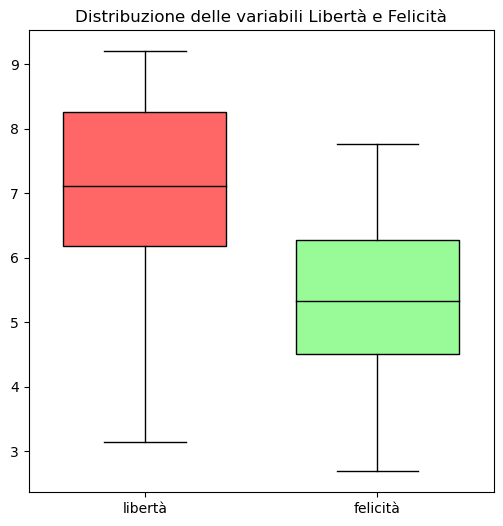

In [489]:
show_boxplot()

In [490]:
#calculation percentage values

freedom_mean = freedom_data.select_dtypes(include=['number']).mean()
freedom_mean = freedom_mean.drop(labels=['year'])

personal_freedom_columns = ['pf_rol', 'pf_ss', 'pf_movement', 'pf_religion', 'pf_expression', 'pf_identity', 'pf_association']
economic_freedom_columns = ['ef_government', 'ef_legal', 'ef_money', 'ef_trade', 'ef_regulation']

total_human_freedom = freedom_mean[['pf_score', 'ef_score']].sum()
total_personal_freedom = freedom_mean[personal_freedom_columns].sum()
total_economic_freedom = freedom_mean[economic_freedom_columns].sum()


h_freedom_percentage = freedom_mean[['pf_score', 'ef_score']]/total_human_freedom
p_freedom_percentage = freedom_mean[personal_freedom_columns]/total_personal_freedom * h_freedom_percentage.pf_score
e_freedom_percentage = freedom_mean[economic_freedom_columns]/total_economic_freedom * h_freedom_percentage.ef_score

freedom_percentage = pd.concat([h_freedom_percentage, p_freedom_percentage, e_freedom_percentage]) * 100

In [491]:
#create pie plot
principal_values = freedom_percentage[['pf_score', 'ef_score']].values
principal_labels = freedom_percentage[['pf_score', 'ef_score']].index

detail_values = freedom_percentage[personal_freedom_columns + economic_freedom_columns].values
detail_labels = freedom_percentage[personal_freedom_columns + economic_freedom_columns].index

blue_colors = sns.color_palette("Blues", 7)
orange_colors = sns.color_palette("Oranges", 5)
colors = blue_colors + orange_colors


# Convert colors to hexadecimal code
personal_colors = [sns.palettes.color_palette([color]).as_hex()[0] for color in blue_colors]
economic_colors = [sns.palettes.color_palette([color]).as_hex()[0] for color in blue_colors]

In [492]:
def freedom_pie_plot():
    principal_labels = freedom_percentage[['pf_score', 'ef_score']].index

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.pie(principal_values, labels=principal_labels, autopct='%1.1f%%')
    plt.title('situazione generale')

    plt.subplot(1, 2, 2)
    plt.pie(detail_values, labels=detail_labels, colors=colors , autopct='%1.1f%%')
    plt.title('dettagli')

    plt.suptitle('Da cosa è composta la libertà')

    plt.tight_layout()

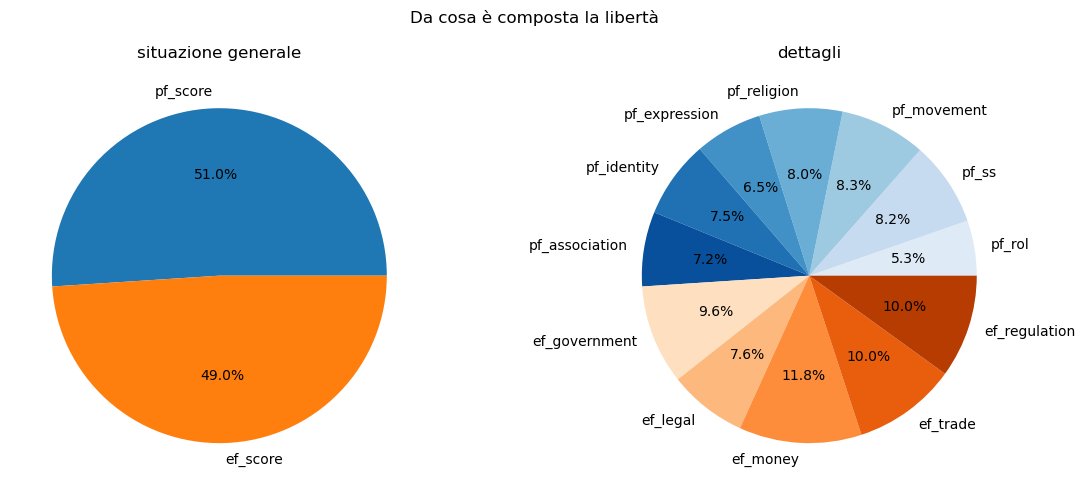

In [493]:
freedom_pie_plot()

In [494]:
principal_columns = ['economy', 'family', 'health', 'freedom', 'trust', 'generosity']

happiness_mean = happiness_data[principal_columns].mean()
happiness_percentage = (happiness_mean / happiness_mean.sum()) * 100

In [495]:
# Happiness pie plot
def happiness_pie_plot():
    plt.figure(figsize=(5, 5))
    plt.pie(happiness_percentage, labels=happiness_percentage.index, autopct='%1.1f%%', startangle=140)
    plt.title('Da cosa è composta la felicità?')
    plt.show()

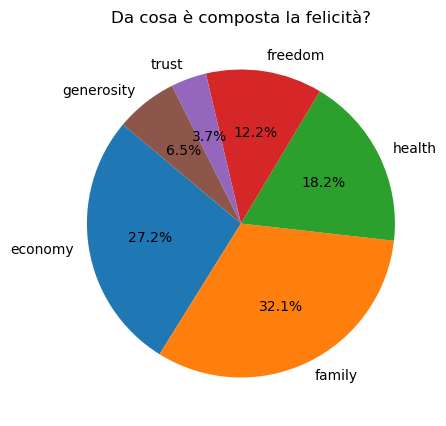

In [496]:
happiness_pie_plot()

<h2>Qual è il legame tra Felicità e Libertà?</h2>

<p>Cercheremo di capire se esiste una relazione significativa tra felicità e libertà e in che modo si influenzano reciprocamente.

A supporto dell'analisi verranno generati i seguenti grafici:</p>
<ul>
    <li><b>Grafico a dispersione</b></li> che permetterà di valutare l'effettiva relazione tra felicità e libertà
    <li><b>Heatmap</b></li> che permetterà di valutare la relazione tra i componenti di felicità e libertà
</ul>


In [497]:
def scatter_plot():
    sns.regplot(data=happy_free, x="happiness_score", y="hf_score", order=1, line_kws=dict(color="r"))
    plt.xlabel('Felicità')
    plt.ylabel('Libertà')
    plt.show()

In [498]:
coefficients = np.polyfit(happy_free.happiness_score, happy_free.hf_score, 1)
m, b = coefficients

print('m: ', m)
print('b: ', b)

m:  0.706703525474513
b:  3.255221043155776


Con retta di regressione: freedom = 0.71 * happiness + 3.26


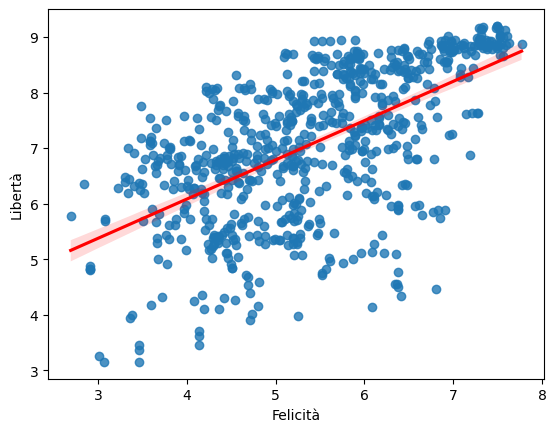

In [499]:
print('Con retta di regressione: freedom =', round(m, 2), '* happiness +', round(b, 2) )
scatter_plot()

In [500]:
heatmap_happy_pfreedom = happy_free[['economy', 'family', 'health',
       'freedom', 'trust', 'generosity',
       'pf_rol', 'pf_ss', 'pf_movement', 'pf_religion', 'pf_expression',
       'pf_identity', 'pf_score','pf_association']]  

heatmap_happy_efreedom = happy_free[['economy', 'family', 'health',
       'freedom', 'trust', 'generosity', 'ef_government', 'ef_legal', 'ef_money',
       'ef_trade', 'ef_regulation']]  

corr_happy_pfreedom = heatmap_happy_pfreedom.corr()
corr_happy_efreedom = heatmap_happy_efreedom.corr()

heatmap_columns = happy_free[['economy', 'family', 'health',
       'freedom', 'trust', 'generosity',
       'pf_rol', 'pf_ss', 'pf_movement', 'pf_religion', 'pf_expression',
       'pf_identity', 'pf_score', 'ef_government', 'ef_legal', 'ef_money',
       'ef_trade', 'ef_regulation', 'pf_association']]  


corr_matrix = heatmap_columns.corr()

In [501]:
#heatmap plot
def heatmap_happy_pfreedom_plot():
    # heatmap for happy_pfreedom
    plt.figure(figsize=(9, 7))
    sns.heatmap(corr_happy_pfreedom, cmap='viridis', annot=True, fmt=".2f")
    plt.title('Heatmap: Felicità - Libertà Personale')
    plt.tight_layout()
    plt.show()

def heatmap_happy_efreedom_plot():
    # heatmap for happy_efreedom
    plt.figure(figsize=(7, 7))
    sns.heatmap(corr_happy_efreedom, cmap='viridis', annot=True, fmt=".2f")
    plt.title('Heatmap: Felicità - Libertà Economica')
    plt.tight_layout()
    plt.show()


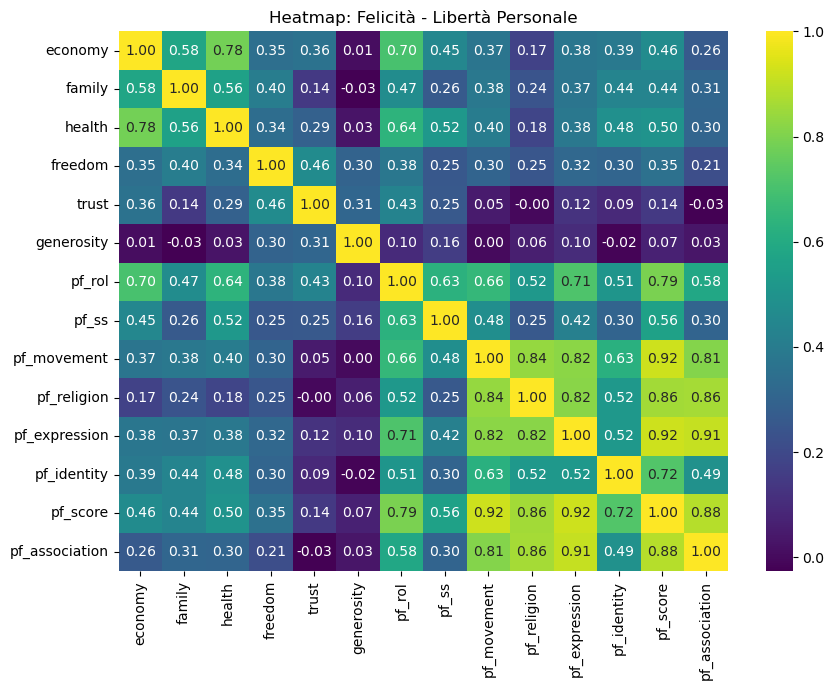

In [502]:
heatmap_happy_pfreedom_plot()

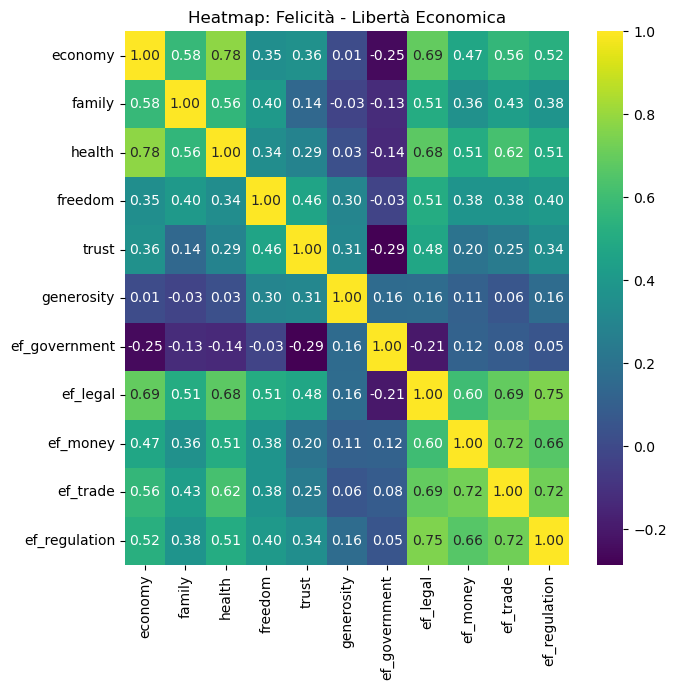

In [503]:
heatmap_happy_efreedom_plot()

<h2>Qual è la percezione Mondiale di Felicità e Libertà?</h2>
<p>Esamineremo la percezione mondiale di felicità e libertà nel periodo preso in considerazione. In prima istanza verrà data una panoramica globale a cui seguiranno le analisi per continente e regione.</p>

<h4>Data Transformation</h4>
Finora abbiamo usato il dataframe 'happy_free' come inner join tra i dataframe 'freedom_data' e 'happiness_data', scelta nata dall'esigenza di non avere dati non valorizzati all'interno delle celle rispetto ai grafici finora prodotti.
Durante la prossima fase di esplorazione, la scelta di procedere con con un'unione così stringente della merge non è sembrata ottimale in quanto causerebbe perdita di dati che invece sarebbe comunque interessante osservare visivamente.

Si procede alla trasformazione del dataframe happy_free:

In [504]:
happy_free_outer = pd.merge(happiness_data, freedom_data,  how='outer', left_on=['country','year'], right_on = ['country','year']) 

In [505]:
columns = happy_free_outer.select_dtypes(include=['float64', 'int64']).columns
columns = columns.drop(['year'])
grouped_by_country = happy_free_outer.groupby('country', as_index=False)[columns].mean()

In [506]:
grouped_by_country = grouped_by_country[['country', 'happiness_score', 'hf_score']]

<p>Per rendere maggiormente evidente la differenza tra le bolle del grafico geopandas, è stata effettuata una normalizzazione dei dati, sfruttando il modulo la libreria StandardScaler, della libreria sklearn</p>

In [507]:
std_scaler = StandardScaler()

happy_free_scaled = std_scaler.fit_transform(happy_free_outer[columns].to_numpy())
happy_free_scaled = pd.DataFrame(happy_free_scaled, columns=happy_free_outer[columns].columns.values)
happy_free_scaled = happy_free_scaled.rename(columns=lambda x: x + '_scaled')

In [508]:
happy_free_scaled.describe()

,happiness_score_scaled,economy_scaled,family_scaled,health_scaled,freedom_scaled,trust_scaled,generosity_scaled,hf_score_scaled,pf_rol_scaled,pf_ss_scaled,...,pf_expression_scaled,pf_identity_scaled,pf_score_scaled,ef_government_scaled,ef_legal_scaled,ef_money_scaled,ef_trade_scaled,ef_regulation_scaled,ef_score_scaled,pf_association_scaled
count,7.820000e+02,7.820000e+02,7.820000e+02,7.820000e+02,7.820000e+02,7.810000e+02,7.820000e+02,8.150000e+02,8.100000e+02,8.150000e+02,...,8.150000e+02,8.150000e+02,8.150000e+02,8.150000e+02,8.150000e+02,8.150000e+02,8.150000e+02,8.150000e+02,8.150000e+02,8.150000e+02
mean,-7.087255e-16,-2.180694e-16,-9.086224e-17,-1.817245e-17,-3.634490e-17,1.000764e-16,1.090347e-16,4.446341e-16,2.631640e-17,-8.718316e-18,...,6.538737e-17,3.007819e-16,3.530918e-16,-5.405356e-16,-2.789861e-16,1.307747e-16,-1.115944e-15,4.489933e-16,2.615495e-16,-8.282400e-17
std,1.000640e+00,1.000640e+00,1.000640e+00,1.000640e+00,1.000640e+00,1.000641e+00,1.000640e+00,1.000614e+00,1.000618e+00,1.000614e+00,...,1.000614e+00,1.000614e+00,1.000614e+00,1.000614e+00,1.000614e+00,1.000614e+00,1.000614e+00,1.000614e+00,1.000614e+00,1.000614e+00
min,-2.383894e+00,-2.250291e+00,-3.274429e+00,-2.467927e+00,-2.690691e+00,-1.186167e+00,-1.788051e+00,-3.016864e+00,-2.219035e+00,-3.751021e+00,...,-2.588602e+00,-2.667156e+00,-3.012690e+00,-2.744783e+00,-2.037164e+00,-5.130856e+00,-4.255625e+00,-4.099205e+00,-4.205564e+00,-2.435168e+00
25%,-7.714925e-01,-7.604102e-01,-6.346983e-01,-6.940689e-01,-6.631861e-01,-6.755225e-01,-7.245911e-01,-7.014443e-01,-7.844566e-01,-4.117138e-01,...,-7.498834e-01,-7.797068e-01,-8.038357e-01,-7.304580e-01,-6.540185e-01,-7.150040e-01,-6.818482e-01,-5.182331e-01,-6.676525e-01,-6.366237e-01
50%,-5.060452e-02,1.625167e-01,1.407143e-01,1.406164e-01,1.303104e-01,-3.256363e-01,-1.357435e-01,5.492611e-02,-2.075558e-01,2.722111e-01,...,1.332908e-01,4.067162e-01,1.588468e-01,2.825742e-02,-1.173416e-01,2.738175e-01,1.096325e-01,8.805995e-02,1.550002e-01,3.209770e-01
75%,7.193190e-01,7.864300e-01,7.556306e-01,7.881707e-01,7.848351e-01,2.893122e-01,4.929272e-01,8.190145e-01,7.846472e-01,7.756438e-01,...,7.250591e-01,7.492947e-01,8.203218e-01,7.199170e-01,6.288574e-01,7.805031e-01,8.531771e-01,6.932357e-01,7.909158e-01,8.401258e-01
max,2.121157e+00,2.898579e+00,1.717410e+00,2.130102e+00,2.048068e+00,4.032905e+00,5.067789e+00,1.652566e+00,2.140859e+00,1.096722e+00,...,1.516931e+00,9.826588e-01,1.481797e+00,2.285604e+00,2.283101e+00,1.104844e+00,1.779604e+00,2.207165e+00,2.143498e+00,1.185812e+00


In [509]:
happy_free_scaled = pd.concat([happy_free_scaled, happy_free_outer], axis=1)
world_merged = world.merge(happy_free_scaled, left_on='name', right_on='country')


In [510]:
# Calculate the centroid of each polygonal geometry
world_merged['centroid'] = world_merged['geometry'].centroid

# Extract the x and y coordinates from the centroid
world_merged['centroid_x'] = world_merged['centroid'].x
world_merged['centroid_y'] = world_merged['centroid'].y

# Add an offset to move the values ​​above zero
offset = abs(world_merged['happiness_score_scaled'].min()) + 1
world_merged['happiness_score_shifted'] = world_merged['happiness_score_scaled'] + offset

# Apply the StandardScaler
world_merged['happiness_score_scaled'] = std_scaler.fit_transform(world_merged[['happiness_score_shifted']])

# Calculate bubble sizes based on scaled happiness_score values
bubble_sizes = np.abs(world_merged['happiness_score_scaled']) * 15

/var/folders/w_/dv5r5z3j0xx6g2nks8s390lm0000gn/T/ipykernel_7424/911940033.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  world_merged['centroid'] = world_merged['geometry'].centroid


In [511]:
def geopandas_plot():
    #this command to avoid ShapelyDeprecationWarning
    warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

    fig, ax = plt.subplots(figsize=(10, 6))
    world_merged.plot(column='hf_score', cmap='viridis', legend=True, ax=ax)

    # Add colored bubbles based on happiness_score
    ax.scatter(world_merged['centroid_x'], world_merged['centroid_y'], 
                s=bubble_sizes, color='red', alpha=0.2)

    # Add country border lines
    world.boundary.plot(ax=ax, color='gray', linewidth=0.5)

    plt.title('Felicità-Libertà nel mondo\n(La dimensione delle bolle è proporzionale alla Felicità,\nIl colore delle nazioni rappresenta la Libertà)')
    plt.show()

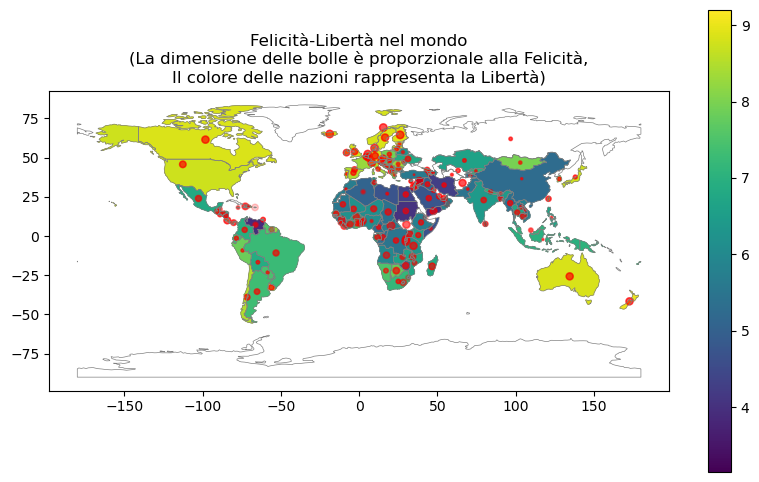

In [512]:
# Create a chart with geopandas
geopandas_plot()

In [513]:
world_happy_free = happy_free.merge(world, left_on="country", right_on="name")

In [514]:
happy_free_by_continents = world_happy_free.groupby('continent')[['happiness_score', 'hf_score']].mean().reset_index()

In [140]:
print('Continenti per media punteggi felicità e libertà')
happy_free_by_continents.sort_values('hf_score', ascending=False).rename(columns={'happiness_score': 'felicità', 'hf_score': 'libertà'})

Continenti per media punteggi felicità e libertà


,continent,felicità,libertà
4,Oceania,7.294600,9.035000
2,Europe,6.159228,8.311304
3,North America,6.099500,7.664853
5,South America,6.126635,7.210192
1,Asia,5.261165,6.450825
0,Africa,4.259495,6.150545


In [137]:
def continent_bar_plot():
    # Data
    continent = happy_free_by_continents['continent'].unique()
    happiness_score_by_region = happy_free_by_continents.groupby('continent')['happiness_score'].mean()
    freedom_score_by_region = happy_free_by_continents.groupby('continent')['hf_score'].mean()

    # Graphics settings
    bar_width = 0.35
    opacity = 0.8
    index = range(len(continent))
    text_height = 0.05

    # Colors settings
    happiness_color = '#98FB98'
    freedom_color = '#FF6666'

    # Creating the bar plot
    plt.figure(figsize=(10, 6))
    bars1 = plt.bar(index, happiness_score_by_region, bar_width, alpha=opacity, color=happiness_color, label='Happiness')
    bars2 = plt.bar([i + bar_width for i in index], freedom_score_by_region, bar_width, alpha=opacity, color=freedom_color, label='Freedom')

    # Add the value of happiness_score on each bar
    for bar, value in zip(bars1, happiness_score_by_region):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + text_height, f'{value:.2f}', ha='center', va='bottom')

    # Add the value of hf_score on each bar
    for bar, value in zip(bars2, freedom_score_by_region):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + text_height, f'{value:.2f}', ha='center', va='bottom')

    # Settings on the x-axis
    plt.title('Score di Felicità e Libertà per Continente')
    plt.xticks([i + bar_width/2 for i in index], continent, rotation=45, ha='right')  # Impostazione della posizione allineata al centro con rotazione

    plt.legend()
    
    plt.tight_layout()
    plt.show()


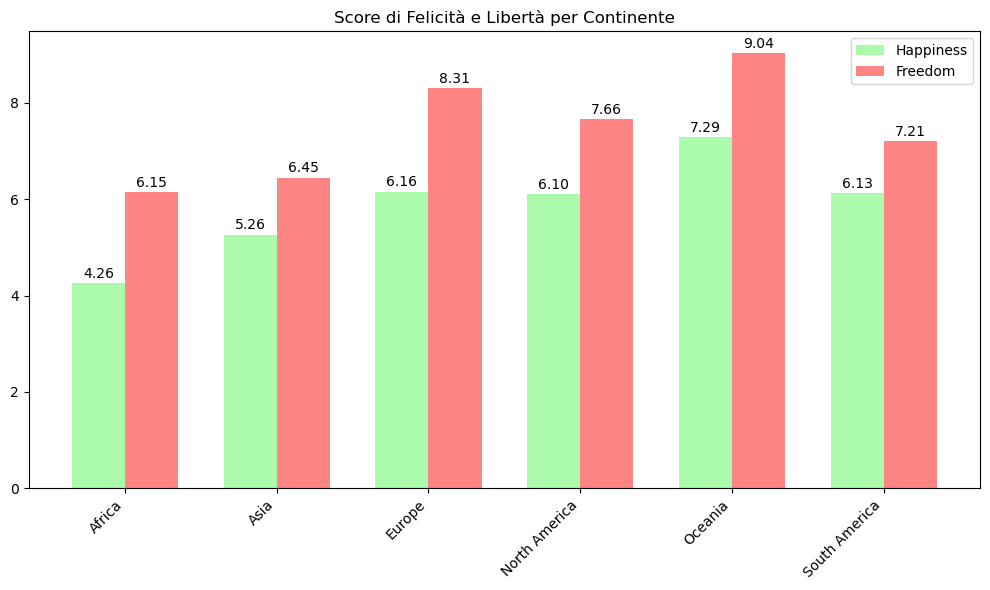

In [138]:
continent_bar_plot()

In [141]:
happy_free_by_region = world_happy_free.groupby('region')[['happiness_score', 'hf_score']].mean().reset_index()

In [171]:
happy_free_by_region.rename(columns={'libertà': 'hf_score', 'felicità': 'happiness_score'}).sort_values('hf_score', ascending=False).assign(
    libertà=lambda x: x['hf_score'],
    felicità=lambda x: x['happiness_score'],
    gap=lambda x: x['hf_score'] - x['happiness_score']
)[['region', 'libertà', 'felicità', 'gap']].round(2)

,region,libertà,felicità,gap
6,Oceania,9.04,7.29,1.74
5,North America,8.86,7.17,1.69
9,Western Europe,8.76,6.96,1.80
2,Eastern Europe,7.97,5.49,2.48
1,East Asia,7.80,5.69,2.11
3,Latin America & the Caribbean,7.34,6.01,1.33
0,Caucasus & Central Asia,6.78,5.01,1.77
7,South Asia,6.32,5.00,1.32
8,Sub-Saharan Africa,6.28,4.14,2.14
4,Middle East & North Africa,5.45,5.33,0.12


In [142]:
happy_free_by_region.sort_values('hf_score', ascending=False)

,region,happiness_score,hf_score
6,Oceania,7.294600,9.035000
5,North America,7.174700,8.860000
9,Western Europe,6.962788,8.764353
2,Eastern Europe,5.494991,7.973486
1,East Asia,5.691320,7.802400
3,Latin America & the Caribbean,6.014582,7.341273
0,Caucasus & Central Asia,5.011800,6.779000
7,South Asia,4.997029,6.321304
8,Sub-Saharan Africa,4.139638,6.278023
4,Middle East & North Africa,5.334624,5.450118


In [157]:
def region_bar_plot():
    # Data
    region = happy_free_by_region['region'].unique()
    happiness_score_by_region = happy_free_by_region['happiness_score']
    freedom_score_by_region = happy_free_by_region['hf_score']

    # Graphics settings
    bar_width = 0.35
    opacity = 0.8
    index = range(len(region))
    text_height = 0.05

    # Colors settings
    happiness_color = '#98FB98'
    freedom_color = '#FF6666'

    # Creating the bar plot
    plt.figure(figsize=(10, 6))
    bars1 = plt.bar(index, happiness_score_by_region, bar_width, alpha=opacity, color=happiness_color, label='Happiness')
    bars2 = plt.bar([i + bar_width for i in index], freedom_score_by_region, bar_width, alpha=opacity, color=freedom_color, label='Freedom')

    # Add the value of happiness_score on each bar
    for bar, value in zip(bars1, happiness_score_by_region):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + text_height, f'{value:.2f}', ha='center', va='bottom')

    # Add the value of hf_score on each bar
    for bar, value in zip(bars2, freedom_score_by_region):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + text_height, f'{value:.2f}', ha='center', va='bottom')

    #  Settings on the x-axis
    plt.title('Score di Felicità e Libertà per Region')
    plt.xticks([i + bar_width/2 for i in index], region, rotation=45, ha='right')  # Impostazione della posizione allineata al centro con rotazione

    plt.legend()

    plt.tight_layout()
    plt.show()


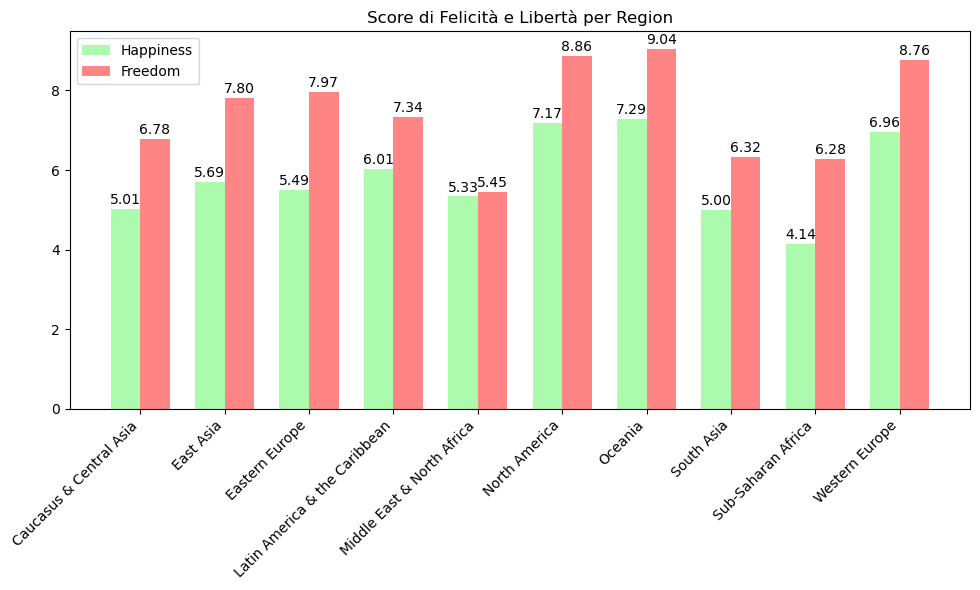

In [158]:
region_bar_plot()

<h2>Serie Storiche</h2>
<p>Sono infine stati estratti una serie di dati inerenti l'evoluzione della felicità e della libertà tra gli anni 2013-2019 e le loro principali componenti, cercando di capire </p>

In [185]:
happy_free_by_year =happy_free_outer.select_dtypes(include=['number']).groupby('year').mean().reset_index()

In [ ]:
#serie storica felicità - libertà (libertà economica- libertà personale)


In [186]:
def trend_happy_free():
    # Plot
    plt.figure(figsize=(10, 6))

    # Plotting happiness_score
    plt.plot(happy_free_by_year['year'], happy_free_by_year['happiness_score'], label='Felicità')

    # Plotting hf_score
    plt.plot(happy_free_by_year['year'], happy_free_by_year['hf_score'], label='Libertà')

    # Plotting pf_score
    plt.plot(happy_free_by_year['year'], happy_free_by_year['pf_score'], label='pf score')

    # Plotting ef_score
    plt.plot(happy_free_by_year['year'], happy_free_by_year['ef_score'], label='ef score')

    plt.title('Serie Storica dei Felicità')
    plt.xlabel('Anno')
    plt.ylabel('Punteggio')
    plt.legend()


    plt.xticks(happy_free_by_year['year'])
    # Show plot
    plt.grid(True)
    plt.tight_layout()
    plt.show()

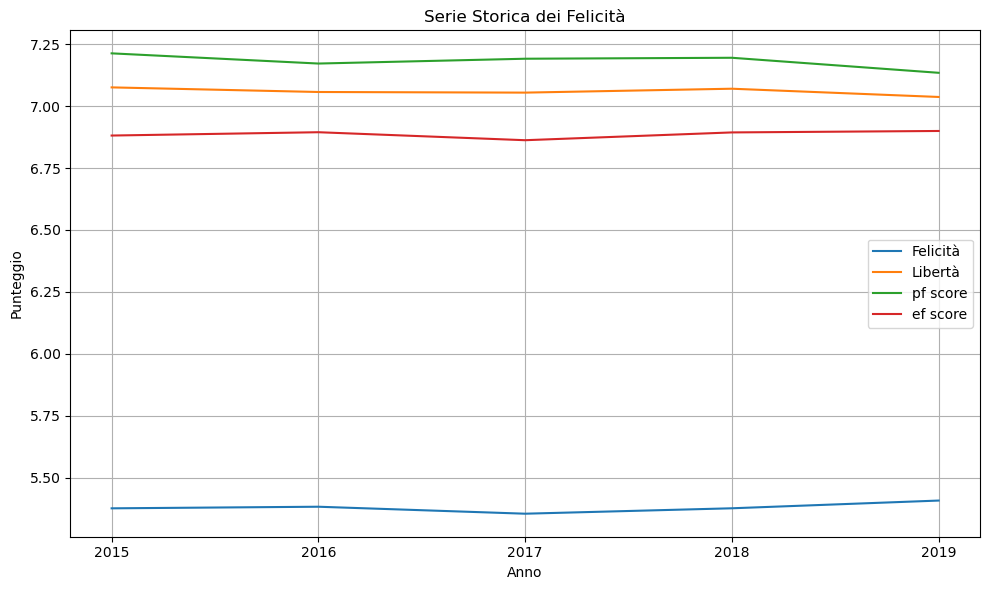

In [187]:
#serie storica felicità - libertà (libertà economica- libertà personale)
trend_happy_free()

In [207]:
top_happiness = happy_free[['country','happiness_score']].groupby('country').mean().reset_index().sort_values('happiness_score', ascending=False).head(3)

In [233]:
top_happiness

,country,happiness_score
38,Denmark,7.5460
104,Norway,7.5410
45,Finland,7.5378


In [209]:
top_happy_score = happy_free[happy_free.country.isin(top_happiness.country)]
top_happy_score = top_happy_score[['country', 'year', 'happiness_score', 'hf_score']].sort_values('year', ascending=True)

In [246]:
def more_happy_trend():
    plt.figure(figsize=(10, 6))

    # Definizione dei colori
    colors = {
        'Denmark': ['#1E64E5', '#2693E5'],  # due sfumature di blu per Denmark
        'Finland': ['#E68410', '#E3BD6D'],  # due sfumature di rosso per Finland
        'Norway': ['#07E815', '#A1E67D']    # due sfumature di verde per Norway
    }

    # Loop per tracciare le linee per ciascun paese
    for country in ['Denmark', 'Finland', 'Norway']:
        country_data = top_happy_score[top_happy_score['country'] == country]
        plt.plot(country_data['year'], country_data['happiness_score'], label=f'{country} Felicità', color=colors[country][0], marker='o')
        plt.plot(country_data['year'], country_data['hf_score'], label=f'{country} Libertà', color=colors[country][1], marker='o')

    # Aggiunta di titolo e legenda
    plt.xticks(happy_free_by_year['year'])
    plt.title('Andamento di Felicità e Libertà nelle 3 nazioni più felici')
    plt.xlabel('Anno')
    plt.legend()


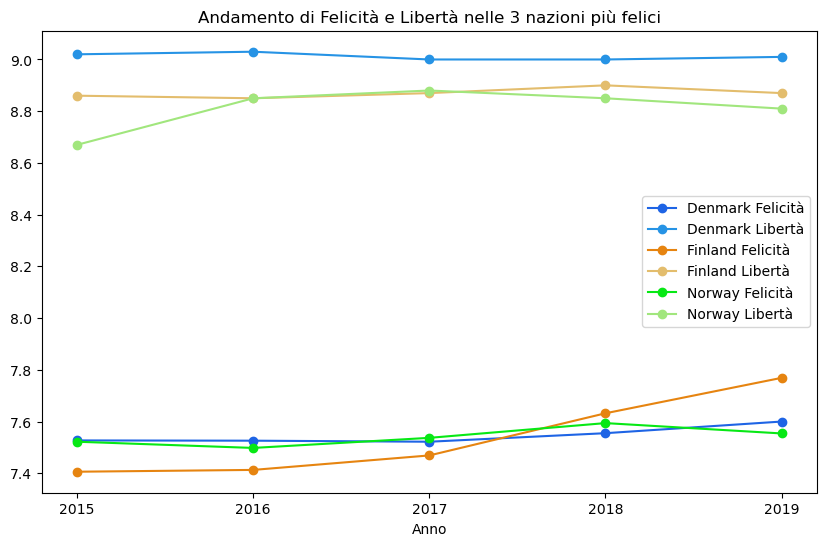

In [247]:
more_happy_trend()

Andamento della felicità e della libertà per i 3 paesi più liberi al mondo

In [248]:
top_freedom = happy_free[['country','hf_score']].groupby('country').mean().reset_index().sort_values('hf_score', ascending=False).head(3)

In [249]:
top_freedom

,country,hf_score
131,Switzerland,9.164
100,New Zealand,9.136
38,Denmark,9.012


In [250]:
top_free_score = happy_free[happy_free.country.isin(top_freedom.country)]
top_free_score = top_free_score[['country', 'year', 'happiness_score', 'hf_score']].sort_values('year', ascending=True)

In [253]:
def more_free_trend():
    plt.figure(figsize=(10, 6))

    # Definizione dei colori
    colors = {
        'Switzerland': ['#1E64E5', '#2693E5'],  # due sfumature di blu per Denmark
        'New Zealand': ['#E68410', '#E3BD6D'],  # due sfumature di rosso per Finland
        'Denmark': ['#07E815', '#A1E67D']    # due sfumature di verde per Norway
    }

    # Loop per tracciare le linee per ciascun paese
    for country in ['Switzerland', 'New Zealand', 'Denmark']:
        country_data = top_free_score[top_free_score['country'] == country]
        plt.plot(country_data['year'], country_data['happiness_score'], label=f'{country} Felicità', color=colors[country][0], marker='o')
        plt.plot(country_data['year'], country_data['hf_score'], label=f'{country} Libertà', color=colors[country][1], marker='o')

    # Aggiunta di titolo e legenda
    plt.xticks(happy_free_by_year['year'])
    plt.title('Andamento di Felicità e Libertà nelle 3 nazioni più libere')
    plt.xlabel('Anno')
    plt.legend()


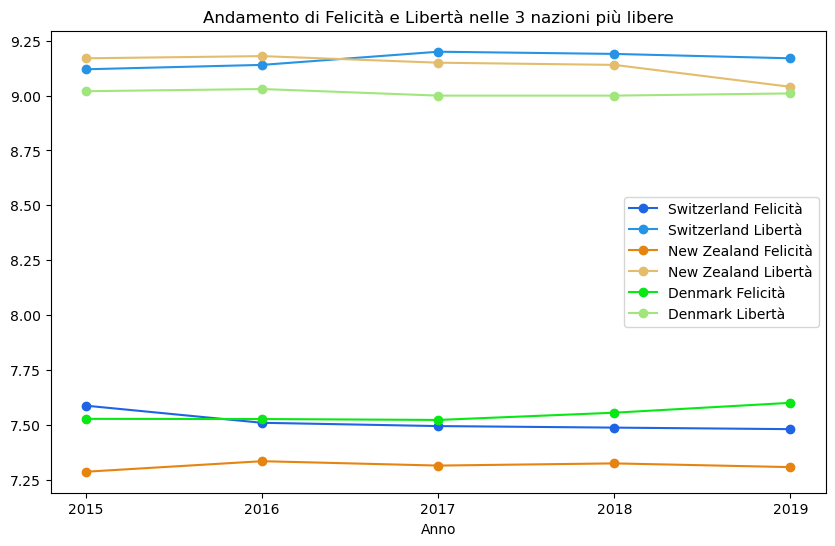

In [254]:
more_free_trend()

In [ ]:
#serie storica componenti libertà economica

In [ ]:
#serie storica componenti felicità

<h2>Conclusioni</h2>

<p>Per chiudere questa panoramica sulla felicità e sulla libertà, possiamo dire che: </p>
<ul>
<li>Ci percepiamo più liberi (mediana = 7.12) che non felici (mediana = 5.32)</li>
<li>E' stato visto che le due variabili sono legate da una relazione: y = 0.71x + 3.26</li>
<li>E' stato messo in evidenza quanto ci sia più correlazione tra felicità e libertà economica piuttosto che tra felicità e libertà personale</li>
<li>E' stata data una panoramica della percezione che le nazioni del mondo hanno rispetto a felicità e libertà</li>
</ul> 